In [1]:
# Cell 1: Imports and device setup

%matplotlib inline
import torch                     # PyTorch:build neural network + tensors + autograd
import torch.nn as nn            # Neural network modules
import torch.optim as optim      # Optimizers (e.g., Adam)
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns            # Heatmaps
import numpy as np               # numpy is the standard numerical library in Python. we use it for arrays

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# Cell 2: Physical parameters and brownie geometry

# --- Material properties (approximate for moist brownie-like food) ---
k   = 0.45        # thermal conductivity [W / (m·K)]
rho = 1050.0      # density [kg / m^3]
cp  = 3300.0      # specific heat [J / (kg·K)]

alpha = k / (rho * cp)  # thermal diffusivity [m^2 / s]
print("Thermal diffusivity alpha [m^2/s]:", alpha)

# --- Geometry: 10 cm x 10 cm square (use meters internally) ---
Lx_cm = 10.0              # x-length in cm
Ly_cm = 10.0              # y-length in cm
Lx     = Lx_cm / 100.0    # convert to meters
Ly     = Ly_cm / 100.0    # convert to meters

# Center (5 cm, 5 cm) in meters
x_center_m = (Lx_cm / 2.0) / 100.0
y_center_m = (Ly_cm / 2.0) / 100.0
print("Center [m]:", x_center_m, y_center_m)

# --- Temperatures ---
T_oven    = 180.0   # boundary temperature [°C]
T_initial = 25.0    # initial internal temperature [°C]

# --- Time setup ---
t_final_minutes = 60.0
t_final_seconds = t_final_minutes * 60.0  # 3600 seconds
print("Final physical time [s]:", t_final_seconds)

# To stabilize PINN training (very important), we do time normalization:
#   t_norm = tau / t_final_seconds  (tau = physical time)
# So t_norm ∈ [0, 1].


Thermal diffusivity alpha [m^2/s]: 1.2987012987012987e-07
Center [m]: 0.05 0.05
Final physical time [s]: 3600.0


In [3]:
# CELL 3
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        
        # Tanh is usually smoother/better for heat equations than Sigmoid
        self.activation = torch.tanh 

        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        
        # Output u in [0, 1] representing normalized temp
        # u = 0 -> 25°C, u = 1 -> 180°C
        # We use Sigmoid to force it between 0 and 1
        return torch.sigmoid(x)

In [4]:
# CELL 4: Sampling Functions (Normalized) ---

def sample_interior_points(N_int):
    """
    Sample dimensionless coordinates [0, 1] for PDE training.
    """
    # Random points in [0, 1]
    x_star = torch.rand(N_int, 1, device=device)
    y_star = torch.rand(N_int, 1, device=device)
    t_star = torch.rand(N_int, 1, device=device)

    x_star.requires_grad_(True)
    y_star.requires_grad_(True)
    t_star.requires_grad_(True)
    return x_star, y_star, t_star

def sample_initial_points(N_ic):
    """
    Initial condition: t=0, Temperature = T_initial (Normalized to 0.0)
    """
    x_star = torch.rand(N_ic, 1, device=device)
    y_star = torch.rand(N_ic, 1, device=device)
    t_star = torch.zeros(N_ic, 1, device=device) # t=0

    # Target is 0.0 (Normalized 25 C)
    u_ic_true = torch.zeros(N_ic, 1, device=device)
    return x_star, y_star, t_star, u_ic_true

def sample_boundary_points(N_bc):
    """
    Boundary condition: Edges, Temperature = T_oven (Normalized to 1.0)
    """
    N_side = N_bc // 4
    
    # Left edge (x=0)
    x_left = torch.zeros(N_side, 1, device=device)
    y_left = torch.rand(N_side, 1, device=device)
    t_left = torch.rand(N_side, 1, device=device)
    
    # Right edge (x=1)
    x_right = torch.ones(N_side, 1, device=device)
    y_right = torch.rand(N_side, 1, device=device)
    t_right = torch.rand(N_side, 1, device=device)
    
    # Bottom edge (y=0)
    y_bottom = torch.zeros(N_side, 1, device=device)
    x_bottom = torch.rand(N_side, 1, device=device)
    t_bottom = torch.rand(N_side, 1, device=device)
    
    # Top edge (y=1)
    y_top = torch.ones(N_side, 1, device=device)
    x_top = torch.rand(N_side, 1, device=device)
    t_top = torch.rand(N_side, 1, device=device)
    
    # Combine
    x_star = torch.cat([x_left, x_right, x_bottom, x_top], dim=0)
    y_star = torch.cat([y_left, y_right, y_bottom, y_top], dim=0)
    t_star = torch.cat([t_left, t_right, t_bottom, t_top], dim=0)
    
    # Target is 1.0 (Normalized 180 C)
    u_bc_true = torch.ones(x_star.shape[0], 1, device=device)
    
    return x_star, y_star, t_star, u_bc_true

In [5]:
# CELL 5
def pde_residual(model, x_norm, y_norm, t_norm):
    input_data = torch.cat([x_norm, y_norm, t_norm], dim=1)
    u = model(input_data)
    
    du_dx = torch.autograd.grad(u, x_norm, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y_norm, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dt = torch.autograd.grad(u, t_norm, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    d2u_dx2 = torch.autograd.grad(du_dx, x_norm, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y_norm, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0]
    
    # Physics Parameters properly scaled
    # PDE: du/dt_norm = (alpha * t_final / L^2) * Laplacian
    
    coeff = (alpha * t_final_seconds) / (Lx**2) 
    
    # Residual
    R = du_dt - coeff * (d2u_dx2 + d2u_dy2)
    return R

Epoch     0 | Total 4.5848e-01 (PDE 1.43e-02, IC 2.45e-01, BC 1.99e-01)
Epoch   500 | Total 1.0618e-01 (PDE 1.10e-02, IC 1.71e-02, BC 7.80e-02)
Epoch  1000 | Total 6.8721e-02 (PDE 1.54e-02, IC 1.24e-02, BC 4.10e-02)
Epoch  1500 | Total 5.4778e-02 (PDE 8.46e-03, IC 1.33e-02, BC 3.30e-02)
Epoch  2000 | Total 8.6212e-02 (PDE 1.27e-02, IC 1.61e-02, BC 5.74e-02)
Epoch  2500 | Total 4.3359e-02 (PDE 4.64e-03, IC 5.02e-03, BC 3.37e-02)
Epoch  3000 | Total 4.5653e-02 (PDE 8.92e-03, IC 6.12e-03, BC 3.06e-02)
Epoch  3500 | Total 3.4778e-02 (PDE 7.71e-03, IC 4.97e-03, BC 2.21e-02)
Epoch  4000 | Total 4.5603e-02 (PDE 1.29e-02, IC 7.36e-03, BC 2.53e-02)
Epoch  4500 | Total 4.0416e-02 (PDE 5.05e-03, IC 2.90e-03, BC 3.25e-02)
Epoch  5000 | Total 3.2956e-02 (PDE 4.53e-03, IC 3.83e-03, BC 2.46e-02)
Epoch  5500 | Total 3.3251e-02 (PDE 6.21e-03, IC 8.92e-03, BC 1.81e-02)


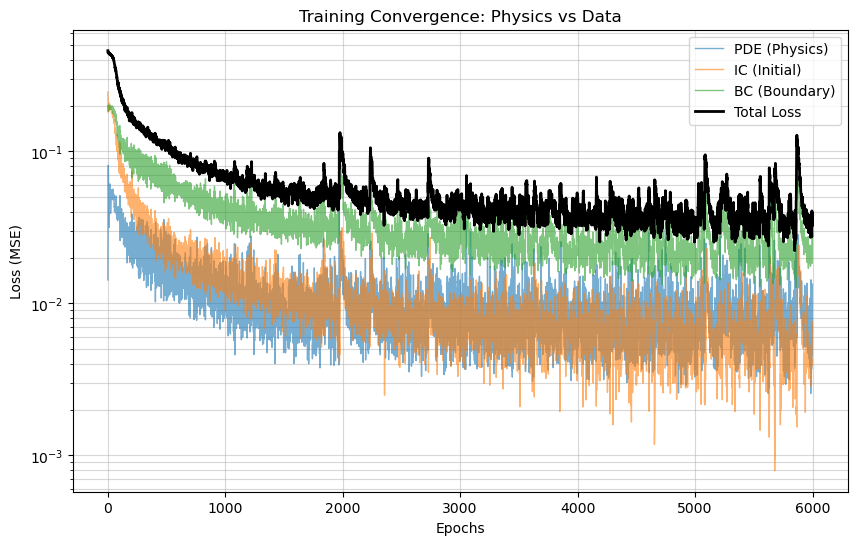

In [6]:
# Cell 6: Training loop with IC, BC, and PDE losses

layers = [3, 64, 64, 64, 64, 1]   # 3 inputs → 4 hidden layers → 1 output
model = PINN(layers).to(device)

mse_loss = nn.MSELoss() # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=1e-3) #learning rate = 1e-3

# Training parameters
num_epochs = 6000 #epoch = iteration
N_int = 2000    # interior points
N_ic  = 500     # initial condition points
N_bc  = 800     # boundary condition points (must be divisible by 4)

# IN CELL 6 (Update the weights section)

# Try equal weighting first. 
# If boundaries are learnt but physics is bad, increase w_pde.
w_pde = 1.0  # Was 1e-3
w_ic  = 1.0  # Was 1e-1
w_bc  = 1.0  # Was 1e-1

# History for plotting
history_epochs     = []
history_loss_total = []
history_loss_pde   = []
history_loss_ic    = []
history_loss_bc    = []

for epoch in range(num_epochs):
    
    optimizer.zero_grad()

    # ===== INTERIOR: PDE physics enforcement =====
    x_int, y_int, t_int = sample_interior_points(N_int)
    R_int = pde_residual(model, x_int, y_int, t_int)
    loss_pde = mse_loss(R_int, torch.zeros_like(R_int))

    # ===== INITIAL CONDITION: T(x,y,0) = T_initial =====
    x_ic, y_ic, t_ic, T_ic = sample_initial_points(N_ic)
    input_ic = torch.cat([x_ic, y_ic, t_ic], dim=1)
    T_ic_pred = model(input_ic)
    loss_ic = mse_loss(T_ic_pred, T_ic)

    # ===== BOUNDARY CONDITION: T = T_oven on all edges =====
    x_bc, y_bc, t_bc, T_bc = sample_boundary_points(N_bc)
    input_bc = torch.cat([x_bc, y_bc, t_bc], dim=1)
    T_bc_pred = model(input_bc)
    loss_bc = mse_loss(T_bc_pred, T_bc)

    # ===== TOTAL LOSS (weighted) =====
    loss = w_pde * loss_pde + w_ic * loss_ic + w_bc * loss_bc

    # Backpropagation (adjust network weights)
    loss.backward()
    optimizer.step()

    # Save history
    history_epochs.append(epoch)
    history_loss_total.append(loss.item())
    history_loss_pde.append(loss_pde.item())
    history_loss_ic.append(loss_ic.item())
    history_loss_bc.append(loss_bc.item())

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total {loss.item():.4e} "
              f"(PDE {loss_pde.item():.2e}, IC {loss_ic.item():.2e}, BC {loss_bc.item():.2e})")


# Cell 7 (Updated): Plot Training Loss

def plot_loss_curves():
    plt.figure(figsize=(10, 6))
    
    # Plot individual components
    plt.plot(history_epochs, history_loss_pde, label='PDE (Physics)', alpha=0.6, linewidth=1)
    plt.plot(history_epochs, history_loss_ic, label='IC (Initial)', alpha=0.6, linewidth=1)
    plt.plot(history_epochs, history_loss_bc, label='BC (Boundary)', alpha=0.6, linewidth=1)
    
    # Plot total loss (thicker line)
    plt.plot(history_epochs, history_loss_total, label='Total Loss', color='black', linewidth=2)
    
    plt.yscale('log')  # Log scale is essential for PINNs
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Convergence: Physics vs Data')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

plot_loss_curves()

Plot successfully saved as: Simulation_Result.png


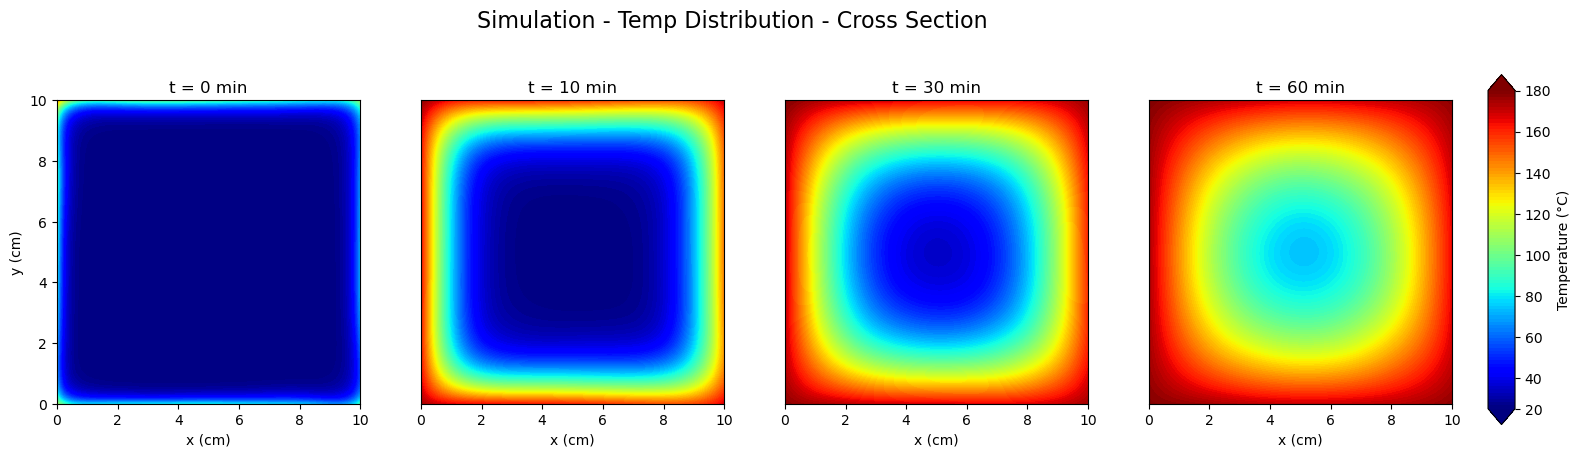

In [9]:
# Cell 8 (Final Fixed Version)

def plot_snapshots_final(times_in_minutes, save_name="brownie_plot.png"):
    #                                      ^ This argument was missing!
    
    # Adjust figsize to be wide enough for square subplots
    fig, axes = plt.subplots(1, len(times_in_minutes), figsize=(18, 5))
    
    x_np = np.linspace(0, Lx, 100)
    y_np = np.linspace(0, Ly, 100)
    X, Y = np.meshgrid(x_np, y_np)
    
    x_torch = torch.tensor(X.flatten() / Lx, dtype=torch.float32).unsqueeze(1).to(device)
    y_torch = torch.tensor(Y.flatten() / Ly, dtype=torch.float32).unsqueeze(1).to(device)

    # Levels and Ticks
    levels = np.linspace(25, 180, 100) 
    cbar_ticks = np.arange(20, 190, 20)

    for i, t_min in enumerate(times_in_minutes):
        ax = axes[i] if len(times_in_minutes) > 1 else axes

        t_val_norm = (t_min * 60.0) / t_final_seconds 
        t_torch = torch.full_like(x_torch, t_val_norm)
        
        with torch.no_grad():
            input_data = torch.cat([x_torch, y_torch, t_torch], dim=1)
            u_pred = model(input_data) 
            T_pred = 25.0 + u_pred * (180.0 - 25.0)
            
        T_grid = T_pred.cpu().numpy().reshape(100, 100)
        
        cp = ax.contourf(X*100, Y*100, T_grid, levels=levels, cmap='jet', extend='both')
        ax.set_aspect('equal')
        
        ax.set_title(f"t = {t_min} min")
        ax.set_xlabel("x (cm)")
        if i == 0:
            ax.set_ylabel("y (cm)")
        else:
            ax.set_yticks([]) 

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    cbar = fig.colorbar(cp, cax=cbar_ax, ticks=cbar_ticks)
    cbar.set_label('Temperature (°C)')
    
    plt.suptitle(f"Simulation - Temp Distribution - Cross Section", fontsize=16)
    
    # Save the figure
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    print(f"Plot successfully saved as: {save_name}")
    
    plt.show()

# Run the function
plot_snapshots_final([0, 10, 30, 60], save_name="Simulation_Result.png")

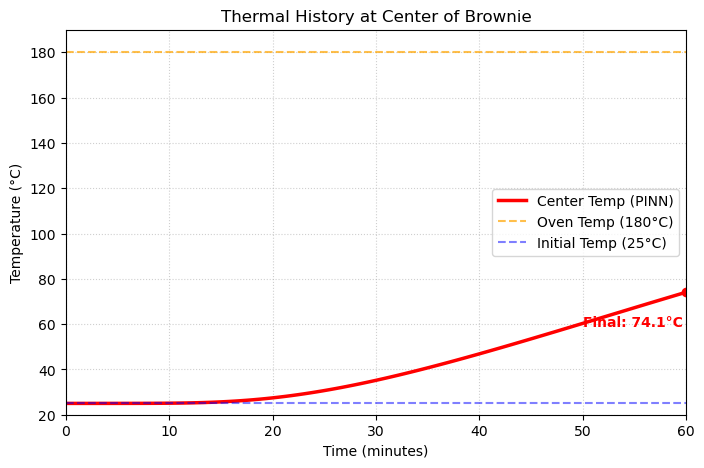

In [8]:
# Cell 8: Center temperature vs time

def plot_center_profile():
    # 1. Define time range (0 to 60 minutes)
    t_minutes = np.linspace(0, t_final_minutes, 100)
    
    # 2. Normalize inputs for the PINN
    # Center is at normalized x=0.5, y=0.5
    x_val = 0.5
    y_val = 0.5
    
    # Create tensors
    # Shape needs to be (N, 1)
    t_norm = torch.tensor(t_minutes * 60 / t_final_seconds, dtype=torch.float32).view(-1, 1).to(device)
    x_norm = torch.full_like(t_norm, x_val)
    y_norm = torch.full_like(t_norm, y_val)
    
    # 3. Predict
    with torch.no_grad():
        input_data = torch.cat([x_norm, y_norm, t_norm], dim=1)
        u_pred = model(input_data)
        
        # Denormalize: u -> T (°C)
        T_pred = 25.0 + u_pred * (180.0 - 25.0)
        
    # Convert to numpy for plotting
    T_center = T_pred.cpu().numpy()
    
    # 4. Plot
    plt.figure(figsize=(8, 5))
    plt.plot(t_minutes, T_center, 'r-', linewidth=2.5, label='Center Temp (PINN)')
    
    # Add reference lines
    plt.axhline(y=180.0, color='orange', linestyle='--', alpha=0.7, label='Oven Temp (180°C)')
    plt.axhline(y=25.0, color='blue', linestyle='--', alpha=0.5, label='Initial Temp (25°C)')
    
    # Formatting
    plt.xlabel("Time (minutes)")
    plt.ylabel("Temperature (°C)")
    plt.title("Thermal History at Center of Brownie")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xlim(0, 60)
    plt.ylim(20, 190)
    
    # Annotate the final temperature
    final_temp = T_center[-1][0]
    plt.plot(60, final_temp, 'ro')
    plt.text(50, final_temp - 15, f"Final: {final_temp:.1f}°C", color='red', fontweight='bold')
    
    plt.show()

plot_center_profile()